In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import cvxpy as cp
from cvxopt import matrix, solvers
import sklearn.covariance as sk_cov
import pyRMT as rmt
from pdb import set_trace as bp

In [2]:
home_dir = os.path.expandvars("$HOME")
app_src_dir = '/dev/repos/FinancialAnalyticsSystem/src'
sys.path.insert(0, home_dir + app_src_dir)


In [3]:
%load_ext autoreload
%autoreload 1
#from DataHandlingSystem.DataLoadingSystem import *
%aimport DataHandlingSystem
%aimport FeatureExtractionSystem
%aimport PortfolioManagementSystem.BackTestingSystem.bt


In [4]:
#import bt
from PortfolioManagementSystem.BackTestingSystem import bt
from DataHandlingSystem.DataLoadingSystem import *
from FeatureExtractionSystem.DeltaFeatureExtractor import * 

In [5]:
sql_pass = str(np.loadtxt('/home/l7/dev/docs/sql_login.txt', dtype=str))
db_name = 'stocks_eod'
owner = 'sql_manager'
data_loader = DataLoadingSystem(db_owner=owner, db_name=db_name, sql_pass=sql_pass)


/home/l7/dev/tools/anaconda3/envs/analytics_system_env_3.6.5/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
start_date = "2000-01-01"
end_date = '2019-01-01'
table_names = ['NVDA', 'MSFT', 'AXP', 'BA', 'CAT', 'BITTI_HE',
              'DAI_DE', 'MC_PA', 'UPM_HE', 'FORTUM_HE']

data_container, smallest_table = get_data_container(table_names=table_names,
                                                   start_date=start_date,
                                                   end_date=end_date,
                                                   data_loader=data_loader)
distance=1
change_df = get_change_data_frame(data_container, smallest_table,
                                 table_names,distance=distance)
change_df = change_df[distance:]

In [7]:
expected_returns = change_df.mean()
print("Number of observations: {}".format(change_df.index.size))
print("expected returns: {}".format(expected_returns))


Number of observations: 4407
expected returns: NVDA         0.001381
MSFT         0.000483
AXP          0.000487
BA           0.000765
CAT          0.000747
BITTI_HE    -0.000007
DAI_DE       0.000283
MC_PA        0.000549
UPM_HE       0.000458
FORTUM_HE    0.000774
dtype: float64


In [8]:
data = pd.DataFrame(columns=table_names)
for table_name in table_names:
    data[table_name] = data_container[table_name]['adjusted close']
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any')

In [9]:
data[:5]

,NVDA,MSFT,AXP,BA,CAT,BITTI_HE,DAI_DE,MC_PA,UPM_HE,FORTUM_HE
date,,,,,,,,,,
2000-06-23 00:00:00+03:00,11.3869,25.2172,36.1322,26.3530,10.4638,122.416206,26.808281,62.177441,4.757380,0.980212
2000-06-26 00:00:00+03:00,12.7555,25.8047,37.8569,26.2671,10.5182,120.152466,26.708200,63.191719,4.873412,0.982639
2000-06-27 00:00:00+03:00,10.9564,25.5808,36.5095,26.4323,10.7841,116.669792,27.056112,62.774864,4.775231,0.987490
2000-06-28 00:00:00+03:00,10.5335,25.6230,35.8762,26.7891,10.9261,120.326591,26.827343,63.136147,4.819860,0.980212
2000-06-29 00:00:00+03:00,9.0157,25.0550,35.3709,27.0534,10.5756,116.843910,26.307861,61.969002,4.819860,0.994769


In [10]:
def calculate_Sigma(X, method_name='sample'):
    sigma = None
    if method_name == 'sample': 
        sigma = np.cov(X.values, rowvar=False)
    elif method_name == 'ledoit-wolf':
        sigma = sk_cov.ledoit_wolf(X.values)[0]
    elif method_name == 'rie' or method_name == 'RIE':
        #bp()
        if X.values.shape[0] <= X.values.shape[1]:
            sigma = sk_cov.ledoit_wolf(X.values)[0]
            #sigma = rmt.optimalShrinkage(X.values, return_covariance=True)
        else:
            sigma = rmt.optimalShrinkage(X.values, return_covariance=True)
    elif method_name =='clipped': 
        if X.values.shape[0] <= X.values.shape[1]:
            sigma = sk_cov.ledoit_wolf(X.values)[0]
            #sigma = rmt.optimalShrinkage(X.values, return_covariance=True)
        else:
            sigma = rmt.clipped(X.values, return_covariance=True)
    else:
        raise Exception('Error occurred with method name: {}'.format(method_name))
        
    return sigma

In [11]:
def calculate_GMVP(sigma):
    N = sigma.shape[0]
    x = cp.Variable(shape=(N,1))
    problem = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, sigma)),
                         [x >= np.ones([N,1]) * 0,
                          np.ones([N,1]).T @ x == 1])
    optimum = problem.solve()
    return x.value, optimum

In [4]:
def calculate_mdp(sigma):
    """
    Maximum Diversified Portfolio
    :param sigma:
    :return:
    """
    N = sigma.shape[0]
    volatilities = np.sqrt(np.diag(sigma))
    x = cp.Variable(shape=(N,1))
    problem = cp.Problem(cp.Maximize((x.T @ volatilities) * 1 / cp.sqrt(cp.quad_form(x, sigma))),
                         [x >= np.ones([N,1]) * 0,
                          np.ones([N,1]).T @ x == 1])
    optimum = problem.solve()
    return x.value, optimum

In [12]:
class WeighMeanVar_local(bt.Algo):

    """
    Sets temp['weights'] based on mean-variance optimization.

    Sets the target weights based on ffn's calc_mean_var_weights. This is a
    Python implementation of Markowitz's mean-variance optimization.

    See:
        http://en.wikipedia.org/wiki/Modern_portfolio_theory#The_efficient_frontier_with_no_risk-free_asset

    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
            each asset in the optimization.
        * covar_method (str): method used to estimate the covariance. See ffn's
            calc_mean_var_weights for more details.
            In addition, RIE and clipping eigenvalues method are also provided for comparison. 
        * rf (float): risk-free rate used in optimization.
        * lag (DateOffset): Number of days to use as the reference return. For example, if there is a
        lag of 3 days, that means that the returns are based on three days prior. 

    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 bounds=(0., 1.), covar_method='ledoit-wolf',
                 rf=0., lag=pd.DateOffset(days=0)):
        super(WeighMeanVar_local, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp['selected']

        if len(selected) == 0:
            target.temp['weights'] = {}
            return True

        if len(selected) == 1:
            target.temp['weights'] = {selected[0]: 1.}
            return True

        t0 = target.now - self.lag
        prc = target.universe[selected].loc[t0 - self.lookback:t0]
        # It calculates the returns every time we compute the weights again.
        returns = prc.to_returns().dropna()
        if returns.index.size > 1:
            returns = returns.dropna()
            sigma = calculate_Sigma(returns, method_name=self.covar_method)
            raw_weights, optimum = calculate_GMVP(sigma)
            for index, weight in enumerate(raw_weights):
                if weight < 0.01: 
                    raw_weights[index] = 0.0
            tw = pd.DataFrame(data=raw_weights.T, columns=prc.columns)
            target.temp['weights'] = tw.dropna()
        else:
            n = len(selected)

            if n == 0:
                target.temp['weights'] = {}
            else:
                w = 1.0 / n
                target.temp['weights'] = {x: w for x in selected}
        return True


In [13]:
lookback=pd.DateOffset(months=12)
lag = pd.DateOffset(months=0)
# q is quantity (number of shares)
# p is price
commission_func = lambda q, p: max(8, abs(q) * abs(p) * 0.003)

In [14]:
method_name = 'ledoit-wolf'
s1 = bt.Strategy(method_name, [bt.algos.RunMonthly(),
                      bt.algos.SelectAll(),
                      WeighMeanVar_local(lookback=lookback,
                                         lag=lag,
                                         covar_method=method_name),
                      bt.algos.Rebalance()])
test1 = bt.Backtest(s1, data, commissions=commission_func)

In [15]:
#result = bt.run(test1)

In [16]:
method_name = 'RIE'
s2 = bt.Strategy(method_name, [bt.algos.RunMonthly(),
                      bt.algos.SelectAll(),
                      WeighMeanVar_local(lookback=lookback,
                                         lag=lag,
                                         covar_method=method_name),
                      bt.algos.Rebalance()])
test2 = bt.Backtest(s2, data, commissions=commission_func)

In [17]:
method_name = 'clipped'
s4 = bt.Strategy(method_name, [bt.algos.RunMonthly(),
                      bt.algos.SelectAll(),
                      WeighMeanVar_local(lookback=lookback,
                                         lag=lag,
                                         covar_method=method_name),
                      bt.algos.Rebalance()])
test4 = bt.Backtest(s4, data, commissions=commission_func)

In [18]:
method_name = 'sample'
s3 = bt.Strategy(method_name, [bt.algos.RunMonthly(),
                      bt.algos.SelectAll(),
                      WeighMeanVar_local(lookback=lookback,
                                         lag=lag,
                                         covar_method=method_name),
                      bt.algos.Rebalance()])
test3 = bt.Backtest(s3, data, commissions=commission_func)

In [19]:
method_name = 'long_only'
s5 = bt.Strategy(method_name, [bt.algos.RunOnce(),
                      bt.algos.SelectAll(),
                      bt.algos.WeighEqually(),
                      bt.algos.Rebalance()])
test5 = bt.Backtest(s5, data, commissions=commission_func)

In [20]:
np.cov(S_s)

NameError: name 'S_s' is not defined

In [228]:
result = bt.run(test1, test2, test3, test4, test5)
#result = bt.run(test1, test2, test5)
# TODO: Something is wrong with the local copy. Must investigate. 


sample
0% [############################# ] 100% | ETA: 00:00:00
clipped
0% [############################# ] 100% | ETA: 00:00:00

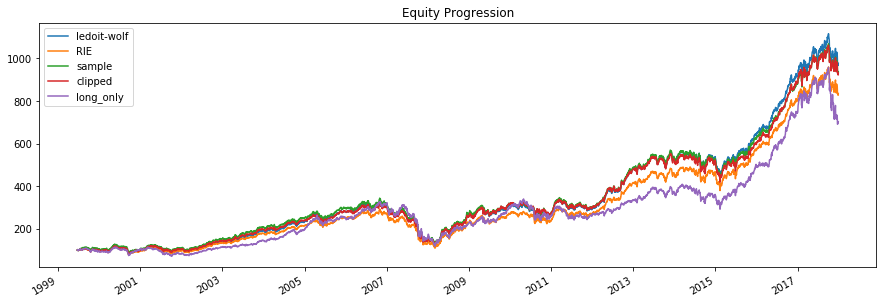

In [229]:
result.plot()

In [230]:
result.display()

Stat                 ledoit-wolf    RIE         sample      clipped     long_only
-------------------  -------------  ----------  ----------  ----------  -----------
Start                2000-06-22     2000-06-22  2000-06-22  2000-06-22  2000-06-22
End                  2018-12-28     2018-12-28  2018-12-28  2018-12-28  2018-12-28
Risk-free rate       0.00%          0.00%       0.00%       0.00%       0.00%

Total Return         877.15%        735.30%     838.11%     831.55%     603.04%
Daily Sharpe         0.76           0.71        0.74        0.74        0.61
Daily Sortino        1.24           1.16        1.21        1.21        0.97
CAGR                 13.10%         12.15%      12.85%      12.81%      11.11%
Max Drawdown         -61.78%        -62.35%     -62.07%     -61.34%     -63.81%
Calmar Ratio         0.21           0.19        0.21        0.21        0.17

MTD                  -4.61%         -4.95%      -4.70%      -5.06%      -7.00%
3m                   -10.87%        -11